<a href="https://colab.research.google.com/github/shadialameddin/tensor_decomposition/blob/master/tensor_decomposition_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://tensorly.org/stable/auto_examples/index.html#general-examples

https://github.com/tensorly/tensorly


Sparse backend

Kruskal-tensors have been renamed cp_tensors

Matrix-product-state has now been renamed tensor-train


In [ ]:
!pip install -U tensorly --quiet

In [1]:
import tensorly as tl
import numpy as np
from tensorly.testing import assert_array_equal

In [ ]:
tensor = tl.tensor(np.arange(24).reshape((3, 4, 2)))
print('* original tensor:\n{}'.format(tensor))

Unfolding a tensor is easy

In [ ]:
for mode in range(tensor.ndim):
    print('* mode-{} unfolding:\n{}'.format(mode, tl.unfold(tensor, mode)))

Re-folding the tensor is as easy:

In [ ]:
for mode in range(tensor.ndim):
    unfolding = tl.unfold(tensor, mode)
    folded = tl.fold(unfolding, mode, tensor.shape)
    assert_array_equal(folded, tensor)

In [1]:
import os 

In [2]:
if not os.path.exists('tensor_decomposition') and not os.path.isfile('TensorDecomp.py'):
    !git clone https://github.com/shadialameddin/tensor_decomposition.git --quiet

In [ ]:
%cd tensor_decomposition

In [1]:
from TensorDecomp import *
import matplotlib.pyplot as plt

list of available decomposition types:

decomp_list = ['svd', 'parafac', 'tucker', 'matrix_product_state', 'NMF','non_negative_parafac', 'clarkson_woodruff_transform']


In [2]:
err_fro  = lambda  x, y : norm(x-y, ord='fro') / norm(x, ord='fro') if (x.ndim == 2) else norm(x-y, ord=None) / norm(x, ord=None)
err_L1   = lambda  x, y : norm(x-y, ord=1) / norm(x, ord=1) if (x.ndim == 2) else norm(x-y, ord=None) / norm(x, ord=None)
err_Linf = lambda  x, y : norm(x-y, ord=inf) / norm(x, ord=inf) if (x.ndim == 2) else norm(x-y, ord=None) / norm(x, ord=None)
err_Spec = lambda  x, y : norm(x-y, ord=2) / norm(x, ord=2) if (x.ndim == 2) else norm(x-y, ord=None) / norm(x, ord=None)
    
normL = [err_fro, err_L1, err_Linf, err_Spec]

In [3]:
aTensor = np.random.randint(20, size = (128,64,6))
vecL = np.random.randint(5, size = aTensor.shape[1])
vecR = np.random.randint(5, size = aTensor.shape[-1])
matL = np.random.randint(5, size = aTensor.shape[:-1])
matR = np.random.randint(5, size = aTensor.shape[-1:-3:-1])
tensor = TensorDecomp(aTensor.astype('float'))

In [4]:
errSvd = errList(tensor, svd, vecR, vecL, matR, matL, normL)
timeSvd = tensor.decomp_time
memSavSvd = tensor.memSaving

In [5]:
errTucker = errList(tensor, tucker, vecR, vecL, matR, matL, normL, rank=[128,64,6])
timeTucker = tensor.decomp_time
memSavTucker = tensor.memSaving

In [6]:
errParafac = errList(tensor, parafac, vecR, vecL, matR, matL, normL, rank=384)
timeParafac = tensor.decomp_time
memSavParafac = tensor.memSaving

In [7]:
errTT  = errList(tensor, matrix_product_state, vecR, vecL, matR, matL, normL, rank=[1,128,128,1])
timeTT = tensor.decomp_time
memSavTT = tensor.memSaving

In [8]:
errNNP  = errList(tensor, non_negative_parafac, vecR, vecL, matR, matL, normL, rank= 384)
timeNNP = tensor.decomp_time
memSavNNP = tensor.memSaving

Text(0, 0.5, 'Memory Saving [-]')

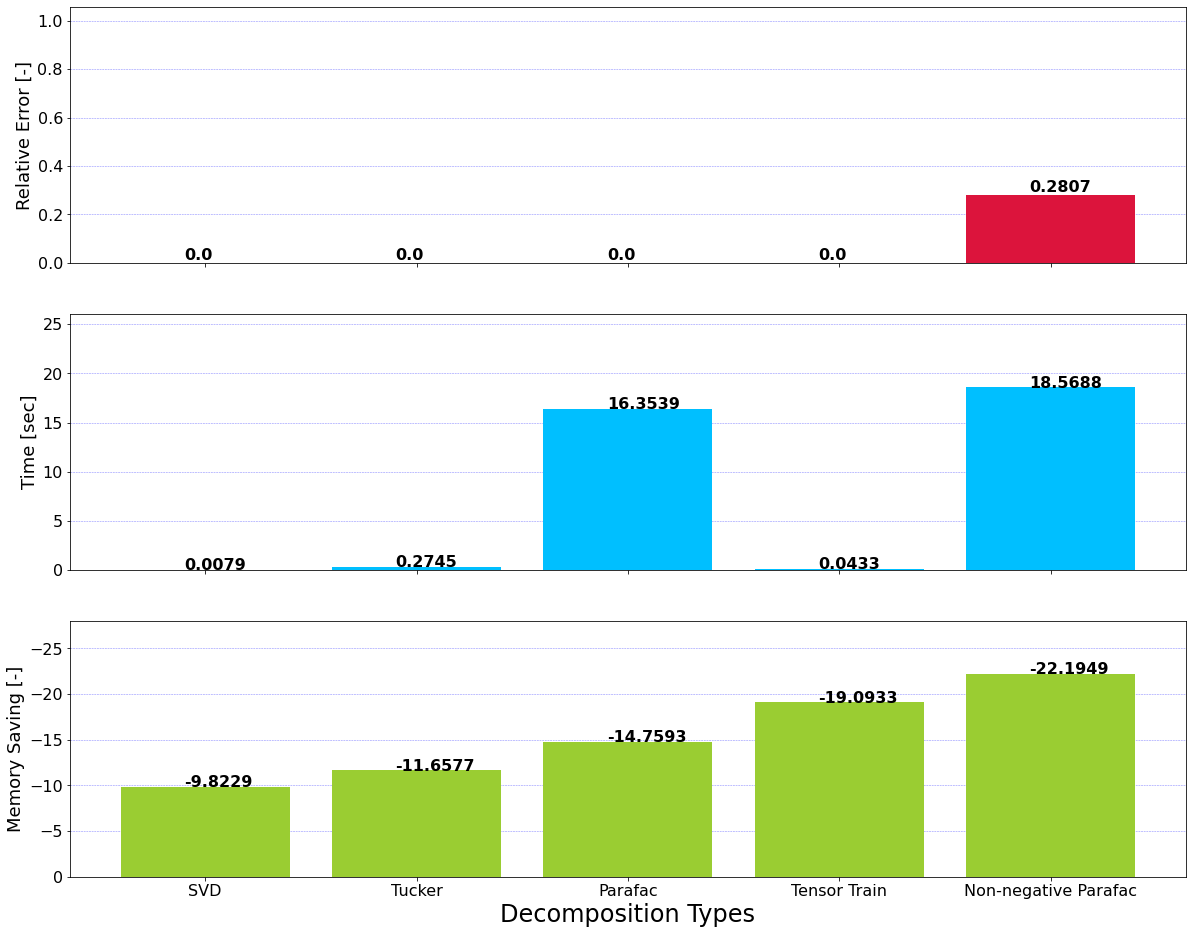

In [9]:
%matplotlib inline

xAxis = ['SVD', 'Tucker', 'Parafac', 'Tensor Train', 'Non-negative Parafac']
y0Axis = [errSvd[0][0], errTucker[0][0], errParafac[0][0], errTT[0][0], errNNP[0][0]]
y1Axis = [timeSvd, timeTucker, timeParafac, timeTT, timeNNP]
y2Axis = [memSavSvd, memSavTucker, memSavParafac, memSavTT, memSavNNP]
colors = ["crimson","deepskyblue", "yellowgreen"]

fig, ax = plt.subplots(3, 1, figsize=(20,16), sharex=True)
for i in range(3):
    ax[i].bar(xAxis, eval('y'+str(i)+'Axis'), color=colors[i])
    ax[i].yaxis.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
    ax[i].set_axisbelow(True)
    ax[i].set_ylim(0, np.ceil(max(eval('y'+str(i)+'Axis'))) + np.mean(eval('y'+str(i)+'Axis'))) if max(eval('y'+str(i)+'Axis')) > 0 else ax[i].set_ylim(0, np.floor(min(eval('y'+str(i)+'Axis')))-5)
    ax[i].tick_params(axis='both', which='major', labelsize=16)
    for h, v in enumerate(eval('y'+str(i)+'Axis')):
        ax[i].text(h-.10, v+.0125, str(np.round(v,4)), color='black', size = 16, weight = "bold")

plt.xlabel("Decomposition Types", fontsize=24)
ax[0].set_ylabel("Relative Error [-]", fontsize=18)
ax[1].set_ylabel("Time [sec]", fontsize=18)
ax[2].set_ylabel("Memory Saving [-]", fontsize=18)

In [10]:
operList = ["tensor.tensor@vectorR", "vectorL@tensor.tensor", "tensor.tensor@MatrixR", "MatrixL@tensor.tensor", "vectorL@tensor.tensor@vectorR", 
"MatrixL@tensor.tensor@MatrixR"]

tensorOperationTimes = tensOpTim(tensor, vecR, vecL, matR, matL, operList)

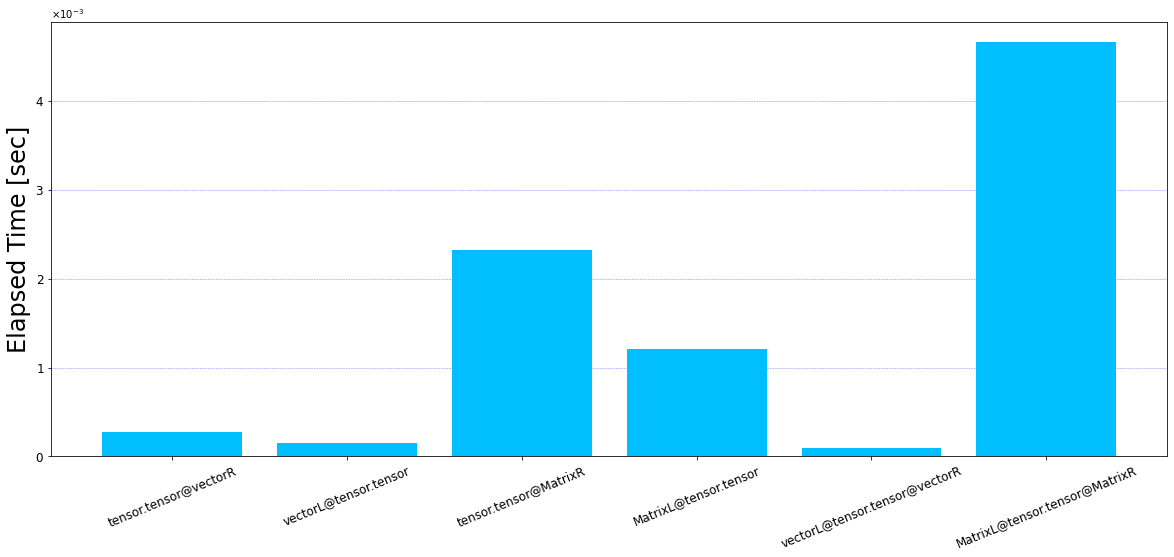

In [18]:
from matplotlib import ticker
uniSlightBlue = '#00BEFF'
fig, ax = plt.subplots(1, 1, figsize=(20,8))
ax.bar(operList, tensorOperationTimes, color = uniSlightBlue)
ax.yaxis.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.xticks(rotation=22.5)
ax.set_axisbelow(True)
ax.set_ylabel("Elapsed Time [sec]", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=12)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter) 

In [1]:
#TODO #1
# Speed comparion is not implemented. No function definition is defined for decomposed_tensor @ Vec multiplication.

In [2]:
#TODO #2
# For every decomposition type -> Line Plot: decomposition error, speedup time in tensor operations vs decomposed tensor operations.

In [4]:
# DONE! (11.07.21)
# For every decomposition type -> Bar plot: Decomposition error, decomposition time, memory saving